In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Suppress Info,Warning

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, \
                    accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
df_train = pd.read_csv('../data/train_cleaned.zip', compression='zip')
df_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."


In [3]:
df_test = pd.read_csv('../data/test_cleaned.zip', compression='zip')
df_test.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank you for understanding i think very highl...,"['thank', 'you', 'for', 'understanding', 'i', ...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highli', 'wo...","[('thank', 'NN'), ('understanding', 'VBG'), ('...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highly', 'wo...","[('thank', 'understanding'), ('understanding',..."


In [4]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: str(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: str(x))

In [5]:
df_train['comment_text'][0], df_train['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

In [6]:
#return dictionary with word: embedding_vector
def load_embedding(fname):
    embeddings_index = {}
    f = open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            embedding_vector = np.asarray(values[1:], dtype='float32')
        except:
            pass
        
        embeddings_index[word] = embedding_vector
    f.close()

    return embeddings_index

# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [8]:
train_text = df_train.clean_text.values
test_text = df_test.clean_text.values

train_target = df_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
test_target = df_test[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values

n_classes=train_target.shape[1]
max_words=20000
max_sequence_length=200
embedding_dims = 300

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(np.concatenate([train_text, test_text]))

#Train
train_sequences = tokenizer.texts_to_sequences(train_text) 
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

#Test
test_sequences = tokenizer.texts_to_sequences(test_text) 
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

word_index = tokenizer.word_index
#embeddings_index = load_embedding("./glove.6B.50d.txt")
embeddings_index = load_embedding("../wiki.simple.vec")

X_train, X_val, y_train, y_val = train_test_split(train_sequences, train_target, test_size=0.2, random_state=100)

In [9]:
filters=128
kernel_size=5

model = Sequential()
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dims))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model.add(Embedding(len(word_index) + 1,
                          embedding_dims,
                          weights=[embedding_matrix],
                          input_length=max_sequence_length,
                          trainable=False))


model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='sigmoid'))

In [10]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), 
                            tf.keras.metrics.Recall()]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          93300300  
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 47, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 43, 128)           8

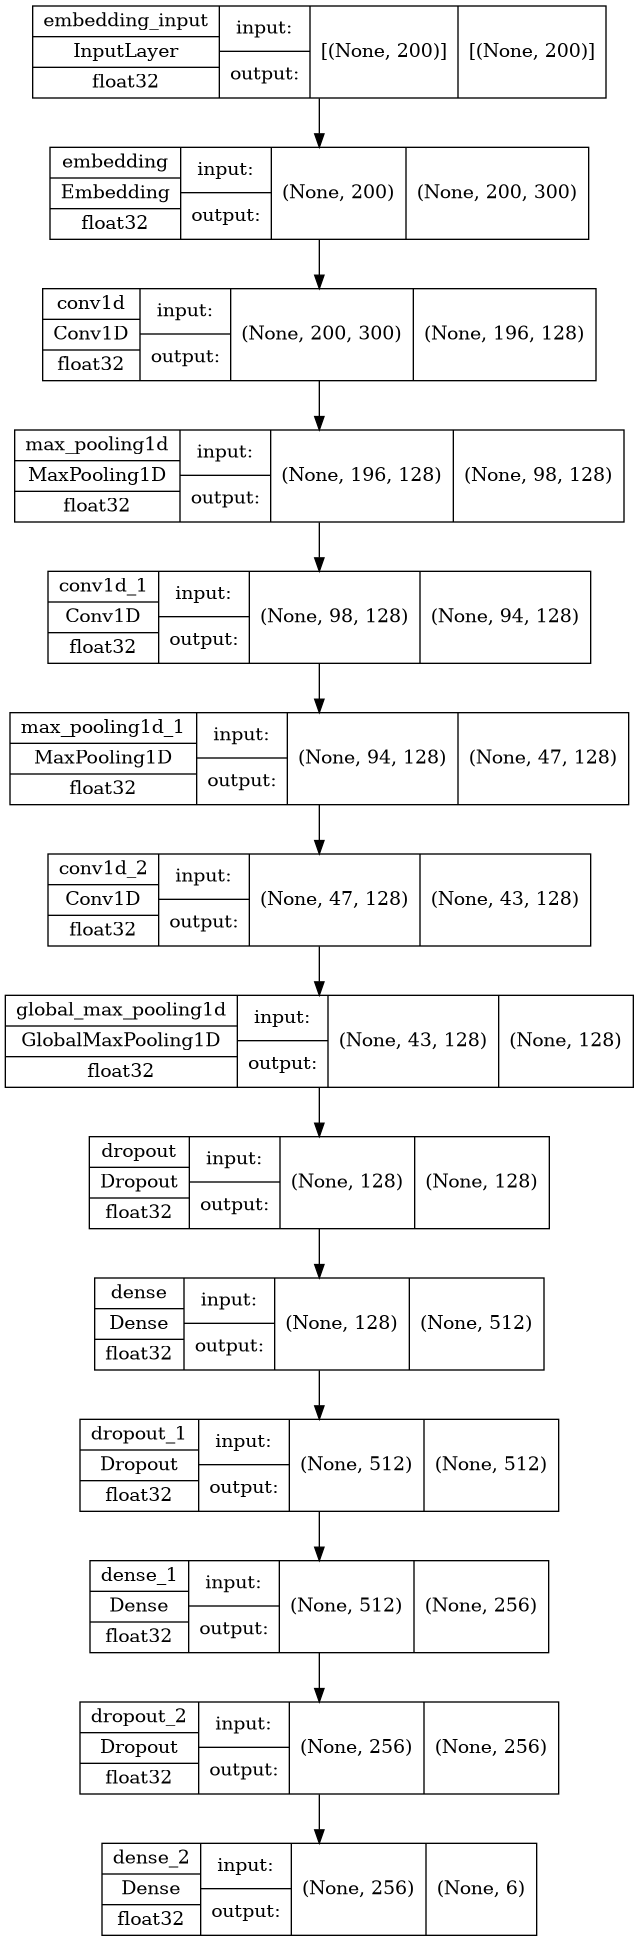

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [16]:
epochs = 20
batch_size=1024

es = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)

history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=batch_size,
          epochs=epochs, callbacks=[es]
            )

Epoch 1/20
125/125 [==============================] - 25s 160ms/step - loss: 0.1337 - auc: 0.8344 - precision: 0.0557 - recall: 0.0079 - val_loss: 0.0969 - val_auc: 0.9418 - val_precision: 0.9505 - val_recall: 0.0273
Epoch 2/20
125/125 [==============================] - 19s 155ms/step - loss: 0.0861 - auc: 0.9371 - precision: 0.7467 - recall: 0.2875 - val_loss: 0.0713 - val_auc: 0.9685 - val_precision: 0.7408 - val_recall: 0.5643
Epoch 3/20
125/125 [==============================] - 20s 157ms/step - loss: 0.0666 - auc: 0.9609 - precision: 0.7817 - recall: 0.5386 - val_loss: 0.0644 - val_auc: 0.9740 - val_precision: 0.7517 - val_recall: 0.6223
Epoch 4/20
125/125 [==============================] - 20s 157ms/step - loss: 0.0594 - auc: 0.9705 - precision: 0.7979 - recall: 0.5840 - val_loss: 0.0636 - val_auc: 0.9727 - val_precision: 0.7221 - val_recall: 0.6574
Epoch 5/20
125/125 [==============================] - 20s 158ms/step - loss: 0.0556 - auc: 0.9744 - precision: 0.8055 - recall: 0.61

In [17]:
history.history

{'loss': [0.1336522102355957,
  0.08605921268463135,
  0.06664761900901794,
  0.05944787710905075,
  0.055570654571056366,
  0.052133914083242416,
  0.04852798953652382,
  0.04578685387969017,
  0.04336490109562874,
  0.04082315042614937,
  0.03912630304694176,
  0.037057071924209595,
  0.03549598157405853,
  0.0346439965069294,
  0.033751651644706726,
  0.032468102872371674,
  0.032094914466142654,
  0.031166689470410347,
  0.02983308956027031,
  0.02936638705432415],
 'auc': [0.8343725800514221,
  0.9370883107185364,
  0.9609465003013611,
  0.9705382585525513,
  0.9743717908859253,
  0.9775064587593079,
  0.9810638427734375,
  0.9839546084403992,
  0.9851962327957153,
  0.9869723916053772,
  0.9880939722061157,
  0.9894160628318787,
  0.9906296730041504,
  0.991142213344574,
  0.9918428063392639,
  0.9926388263702393,
  0.9925761818885803,
  0.9929917454719543,
  0.9938316345214844,
  0.9941594004631042],
 'precision': [0.055708907544612885,
  0.7466691136360168,
  0.7817185521125793

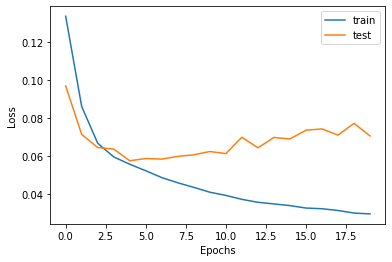

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

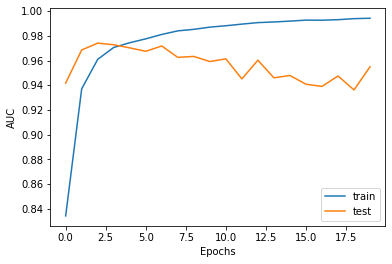

In [19]:
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

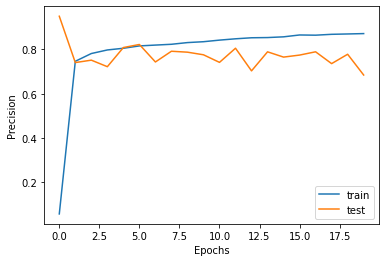

In [20]:
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

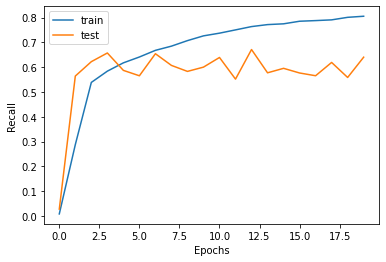

In [21]:
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [22]:
y_prob = model.predict(X_test)
y_pred = y_prob.round()

In [23]:
print(classification_report(test_target, y_pred))
multilabel_confusion_matrix(test_target, y_pred)

              precision    recall  f1-score   support

           0       0.44      0.85      0.58      6090
           1       0.40      0.32      0.35       367
           2       0.71      0.58      0.64      3691
           3       0.00      0.00      0.00       211
           4       0.61      0.51      0.55      3427
           5       0.20      0.00      0.00       712

   micro avg       0.51      0.63      0.56     14498
   macro avg       0.39      0.38      0.35     14498
weighted avg       0.53      0.63      0.55     14498
 samples avg       0.08      0.06      0.06     14498



array([[[51258,  6630],
        [  935,  5155]],

       [[63438,   173],
        [  251,   116]],

       [[59425,   862],
        [ 1547,  2144]],

       [[63767,     0],
        [  211,     0]],

       [[59435,  1116],
        [ 1690,  1737]],

       [[63262,     4],
        [  711,     1]]])

In [24]:
print(f'Accuracy score: {accuracy_score(test_target, y_pred)}')

Accuracy score: 0.8323798805839507


In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_target[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [26]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_target.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
print(roc_auc["micro"])

0.958060424890897


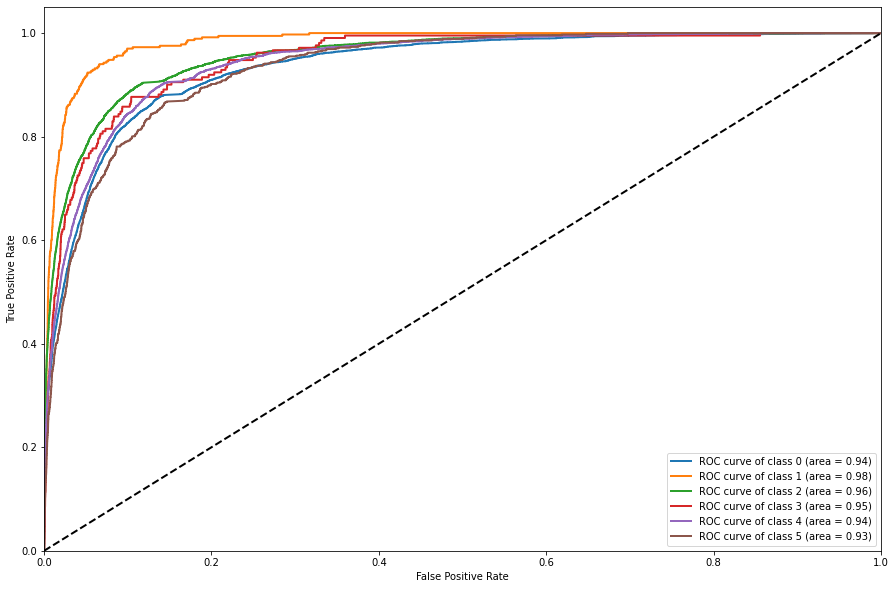

In [28]:
plt.figure(figsize=(15,10))
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()